In [47]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import warnings
warnings.filterwarnings(action = 'ignore')

# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

#### Dataset 불러오기

In [48]:
kospi_all = pd.read_csv('./dataset/data_kospi_all.csv')
kospi_bad = pd.read_csv('./dataset/data_kospi_bad.csv')
kospi_good = pd.read_csv('./dataset/data_kospi_good.csv')
kosdaq_all = pd.read_csv('./dataset/data_kosdaq_all.csv')
kosdaq_bad = pd.read_csv('./dataset/data_kosdaq_bad.csv')
kosdaq_good = pd.read_csv('./dataset/data_kosdaq_good.csv')

#### 함수

##### train, test 분리 + 데이터 불균형 처리 + 스케일링

In [49]:
def data(df):
    features = df.drop(['target'], axis=1)
    target = df[['target']]

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    # X_train, y_train = ADASYN(random_state=121).fit_resample(X_train, y_train)
    X_train, y_train = TomekLinks(sampling_strategy = 'not majority').fit_resample(X_train, y_train) # not majority(Good), majority, all
    # X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [50]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [51]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### Logistic Regression

In [52]:
def LG(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()
    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

##### Decision Tree

In [53]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [54]:
def DT_vis(df, best_model):
    export_graphviz(best_model.best_estimator_, out_file='bankruptcy.dot', class_names=["0", "1"], feature_names= df.drop(['target'], axis=1).columns, impurity=True, filled=True)

    with open('bankruptcy.dot', encoding='utf-8') as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

##### SVM

In [55]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

##### XGBoost

In [56]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

____

#### 코스피

##### All

Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.11235613788450882

예측 데이터 정확도
accuracy score : 0.607
precision score : 0.111
recall score : 0.636
f1 score : 0.189
roc score : 0.620
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.07208    0.07208 1.00000   0.13447    0.50000
0.30000   0.08126    0.07275 1.00000   0.13564    0.50494
0.40000   0.19659    0.07727 0.92727   0.14266    0.53355
0.50000   0.60682    0.11111 0.63636   0.18919    0.62044
0.60000   0.84666    0.08108 0.10909   0.09302    0.50652
0.70000   0.91481    0.18750 0.05455   0.08451    0.51809
0.80000   0.92792    0.00000 0.00000   0.00000    0.50000
0.90000   0.92792    0.00000 0.00000   0.00000    0.50000
None


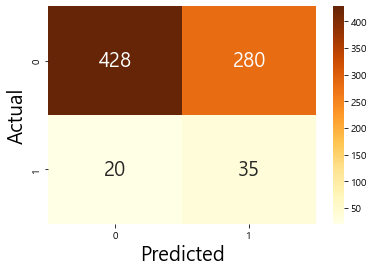

In [57]:
LG(kospi_all)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.11388036713319143

예측 데이터 정확도
accuracy score : 0.818
precision score : 0.080
recall score : 0.145
f1 score : 0.103
roc score : 0.508
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.31324    0.06494 0.63636   0.11785    0.46225
0.30000   0.31324    0.06494 0.63636   0.11785    0.46225
0.40000   0.33552    0.06202 0.58182   0.11208    0.44910
0.50000   0.81782    0.08000 0.14545   0.10323    0.50776
0.60000   0.81782    0.08000 0.14545   0.10323    0.50776
0.70000   0.84010    0.08642 0.12727   0.10294    0.51138
0.80000   0.86370    0.11111 0.12727   0.11864    0.52409
0.90000   0.91743    0.10000 0.01818   0.03077    0.50273
None


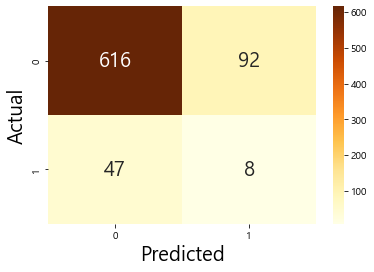

In [58]:
p_all = DT(kospi_all)

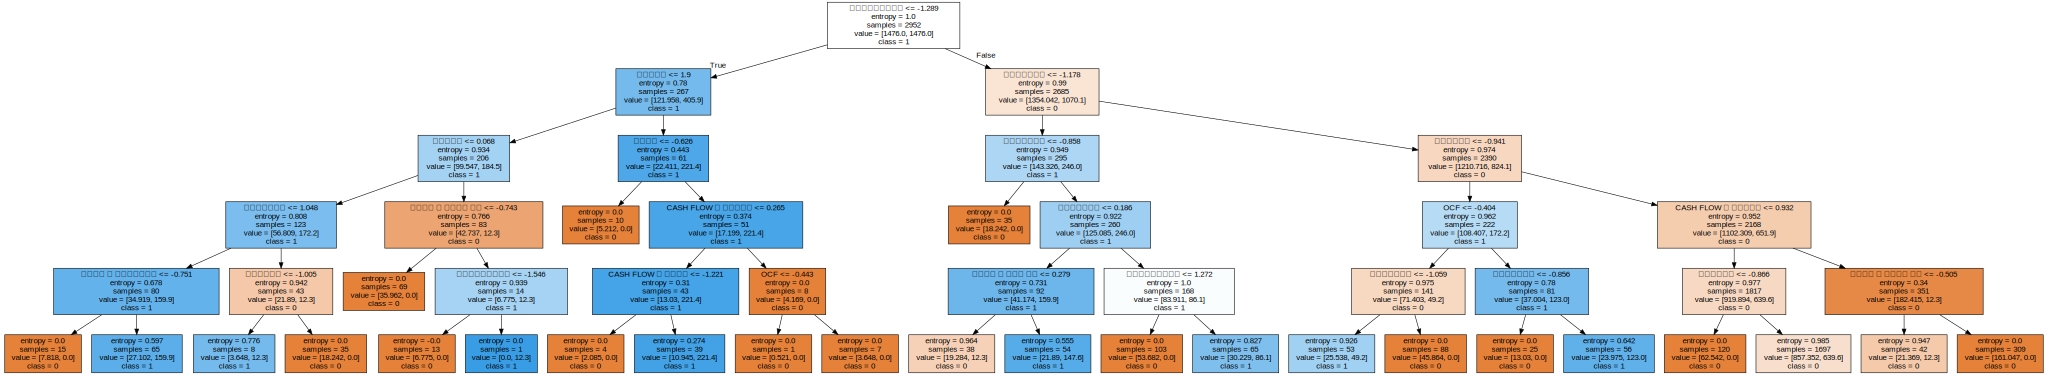

In [59]:
DT_vis(kospi_all, p_all)

SVM

최적 파라미터
 {'C': 0.5, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.14491713736996756

예측 데이터 정확도
accuracy score : 0.789
precision score : 0.066
recall score : 0.145
f1 score : 0.090
roc score : 0.492


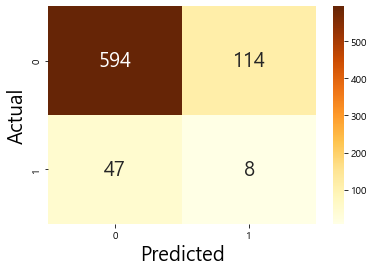

In [60]:
SVM(kospi_all, 'rbf')

In [61]:
# SVM(kospi_all, 'linear')

XGBoost

[21:26:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'gamma': 10.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 12.967032967032967, 'silent': 1}
학습 데이터 정확도 :  0.16645315468844882

예측 데이터 정확도
accuracy score : 0.910
precision score : 0.062
recall score : 0.018
f1 score : 0.028
roc score : 0.498
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.83879    0.11364 0.18182   0.13986    0.53582
0.30000   0.88729    0.13953 0.1090

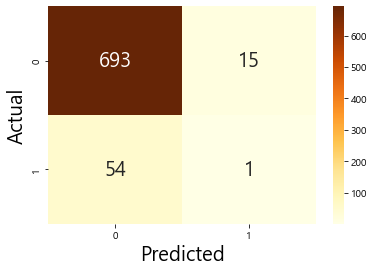

In [62]:
XGB(kospi_all)

##### 부정

Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.06298342606067767

예측 데이터 정확도
accuracy score : 0.648
precision score : 0.056
recall score : 0.361
f1 score : 0.097
roc score : 0.512
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.05240    0.05240 1.00000   0.09959    0.50000
0.30000   0.05240    0.05240 1.00000   0.09959    0.50000
0.40000   0.12809    0.05104 0.88889   0.09653    0.48746
0.50000   0.64774    0.05603 0.36111   0.09701    0.51235
0.60000   0.86608    0.06250 0.11111   0.08000    0.50947
0.70000   0.92868    0.11765 0.05556   0.07547    0.51626
0.80000   0.94760    0.00000 0.00000   0.00000    0.50000
0.90000   0.94760    0.00000 0.00000   0.00000    0.50000
None


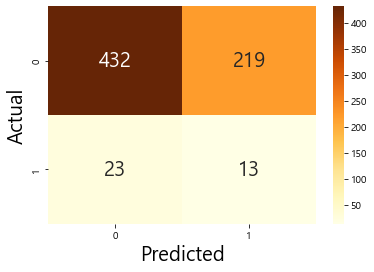

In [63]:
LG(kospi_bad)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.07448498066818678

예측 데이터 정확도
accuracy score : 0.702
precision score : 0.075
recall score : 0.417
f1 score : 0.128
roc score : 0.567
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.70160    0.07538 0.41667   0.12766    0.56701
0.30000   0.70160    0.07538 0.41667   0.12766    0.56701
0.40000   0.70160    0.07538 0.41667   0.12766    0.56701
0.50000   0.70160    0.07538 0.41667   0.12766    0.56701
0.60000   0.70160    0.07538 0.41667   0.12766    0.56701
0.70000   0.77584    0.05970 0.22222   0.09412    0.51434
0.80000   0.86317    0.08571 0.16667   0.11321    0.53418
0.90000   0.93450    0.20000 0.08333   0.11765    0.53245
None


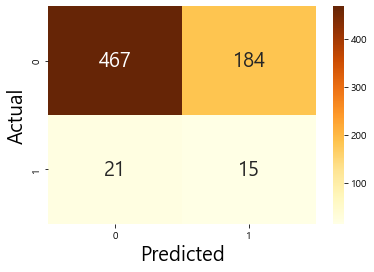

In [64]:
p_bad = DT(kospi_bad)

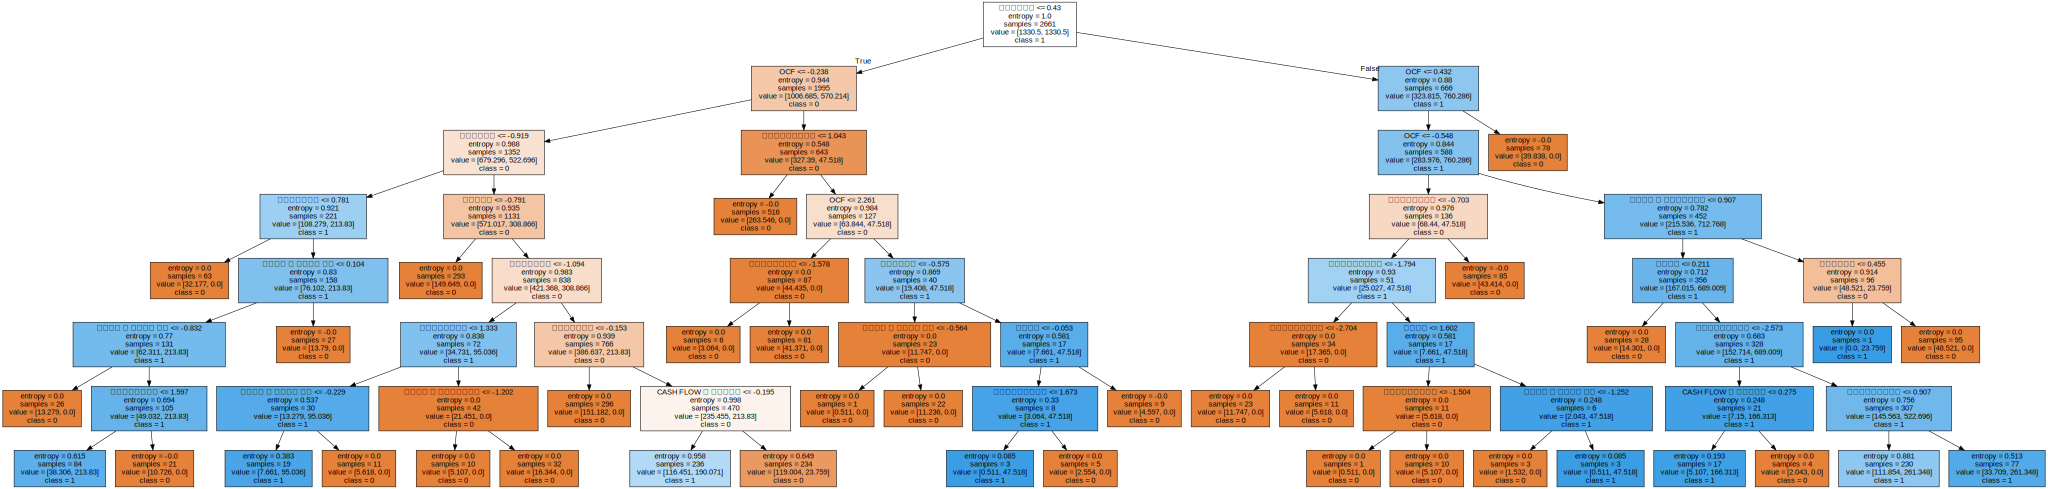

In [65]:
DT_vis(kospi_bad, p_bad)

SVM

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.07332667332667334

예측 데이터 정확도
accuracy score : 0.905
precision score : 0.086
recall score : 0.083
f1 score : 0.085
roc score : 0.517


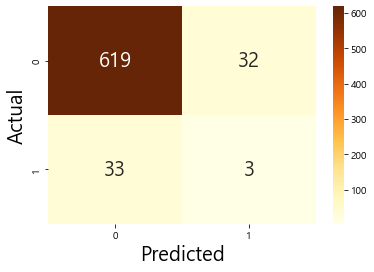

In [66]:
SVM(kospi_bad, 'rbf')

In [67]:
# SVM(kospi_bad, 'linear')

XGB

[21:29:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 18.189944134078214, 'silent': 1}
학습 데이터 정확도 :  0.09273521969174144

예측 데이터 정확도
accuracy score : 0.934
precision score : 0.091
recall score : 0.028
f1 score : 0.043
roc score : 0.506
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.76274    0.06207 0.25000   0.09945    0.52055
0.30000   0.86463    0.06154 0.1111

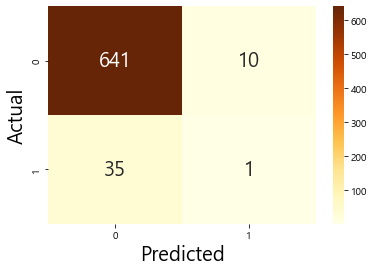

In [68]:
XGB(kospi_bad)

##### 건전

Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.33024717218265603

예측 데이터 정확도
accuracy score : 0.592
precision score : 0.324
recall score : 0.579
f1 score : 0.415
roc score : 0.588
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.25000    0.25000 1.00000   0.40000    0.50000
0.30000   0.25000    0.25000 1.00000   0.40000    0.50000
0.40000   0.25000    0.25000 1.00000   0.40000    0.50000
0.50000   0.59211    0.32353 0.57895   0.41509    0.58772
0.60000   0.75000    0.00000 0.00000   0.00000    0.50000
0.70000   0.75000    0.00000 0.00000   0.00000    0.50000
0.80000   0.75000    0.00000 0.00000   0.00000    0.50000
0.90000   0.75000    0.00000 0.00000   0.00000    0.50000
None


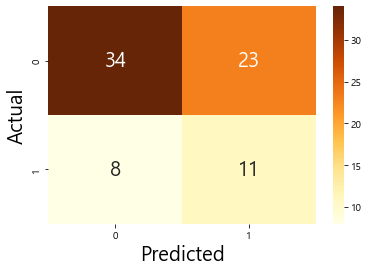

In [69]:
LG(kospi_good)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.2787549087549087

예측 데이터 정확도
accuracy score : 0.539
precision score : 0.310
recall score : 0.684
f1 score : 0.426
roc score : 0.588
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.53947    0.30952 0.68421   0.42623    0.58772
0.30000   0.53947    0.30952 0.68421   0.42623    0.58772
0.40000   0.53947    0.30952 0.68421   0.42623    0.58772
0.50000   0.53947    0.30952 0.68421   0.42623    0.58772
0.60000   0.75000    0.50000 0.26316   0.34483    0.58772
0.70000   0.75000    0.50000 0.26316   0.34483    0.58772
0.80000   0.73684    0.00000 0.00000   0.00000    0.49123
0.90000   0.75000    0.00000 0.00000   0.00000    0.50000
None


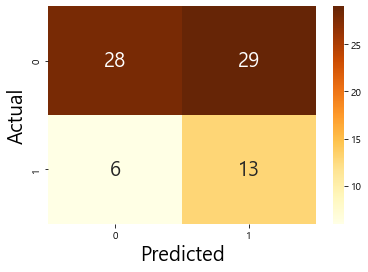

In [70]:
p_good = DT(kospi_good)

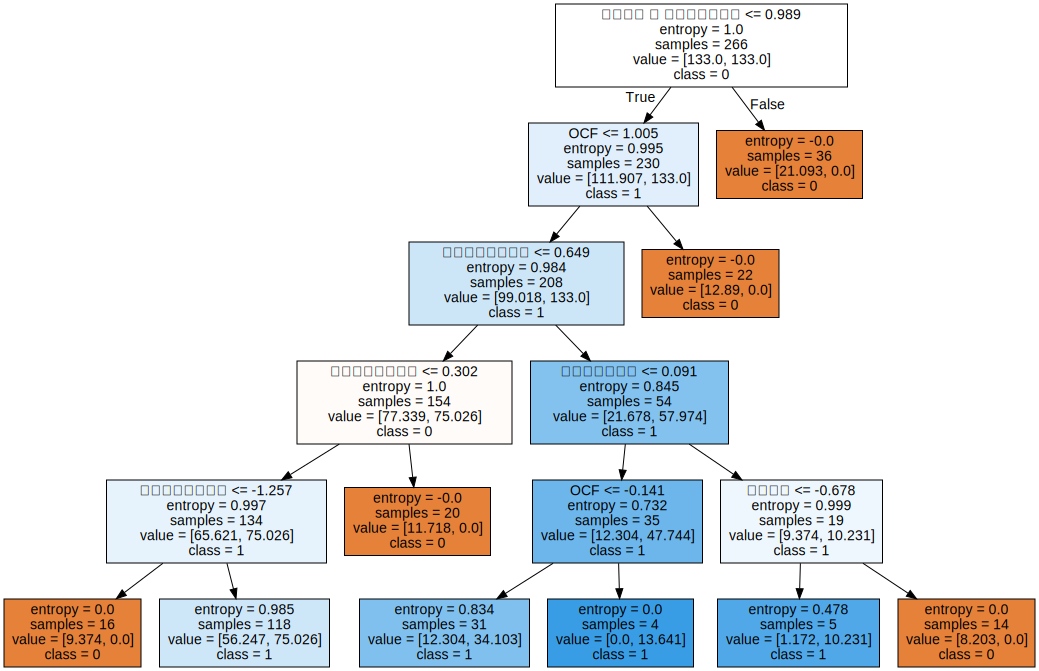

In [71]:
DT_vis(kospi_good, p_good)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.32403351895480836

예측 데이터 정확도
accuracy score : 0.632
precision score : 0.345
recall score : 0.526
f1 score : 0.417
roc score : 0.596


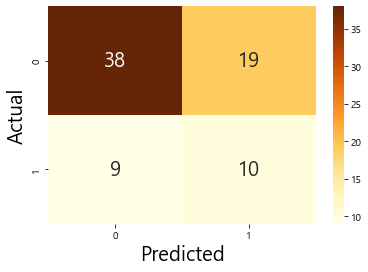

In [72]:
SVM(kospi_good, 'rbf')

In [73]:
# SVM(kospi_good, 'linear')

XGB

[21:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 3.021276595744681, 'silent': 1}
학습 데이터 정확도 :  0.1896969696969697

예측 데이터 정확도
accuracy score : 0.711
precision score : 0.364
recall score : 0.211
f1 score : 0.267
roc score : 0.544
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.65789    0.34783 0.42105   0.38095    0.57895
0.30000   0.69737    0.38889 0.36842  

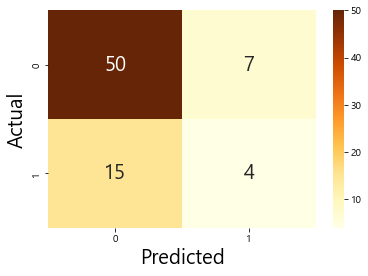

In [74]:
XGB(kospi_good)

#### 코스닥

##### ALL

Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.12027936293892842

예측 데이터 정확도
accuracy score : 0.549
precision score : 0.117
recall score : 0.472
f1 score : 0.187
roc score : 0.515
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.11002    0.11002 1.00000   0.19823    0.50000
0.30000   0.11002    0.11002 1.00000   0.19823    0.50000
0.40000   0.11002    0.11002 1.00000   0.19823    0.50000
0.50000   0.54919    0.11670 0.47154   0.18710    0.51517
0.60000   0.88998    0.00000 0.00000   0.00000    0.50000
0.70000   0.88998    0.00000 0.00000   0.00000    0.50000
0.80000   0.88998    0.00000 0.00000   0.00000    0.50000
0.90000   0.88998    0.00000 0.00000   0.00000    0.50000
None


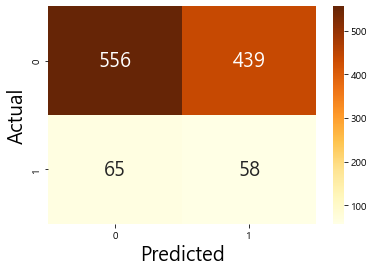

In [75]:
LG(kosdaq_all)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.1333960465124148

예측 데이터 정확도
accuracy score : 0.712
precision score : 0.133
recall score : 0.293
f1 score : 0.183
roc score : 0.528
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.28444    0.10317 0.71545   0.18033    0.47330
0.30000   0.34705    0.10839 0.68293   0.18708    0.49423
0.40000   0.39177    0.10271 0.58537   0.17476    0.47660
0.50000   0.71199    0.13284 0.29268   0.18274    0.52825
0.60000   0.71199    0.13284 0.29268   0.18274    0.52825
0.70000   0.80322    0.13534 0.14634   0.14062    0.51538
0.80000   0.83453    0.13095 0.08943   0.10628    0.50803
0.90000   0.87835    0.11765 0.01626   0.02857    0.50059
None


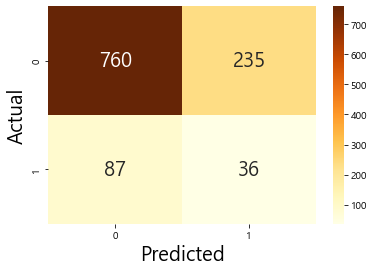

In [76]:
d_all = DT(kosdaq_all)

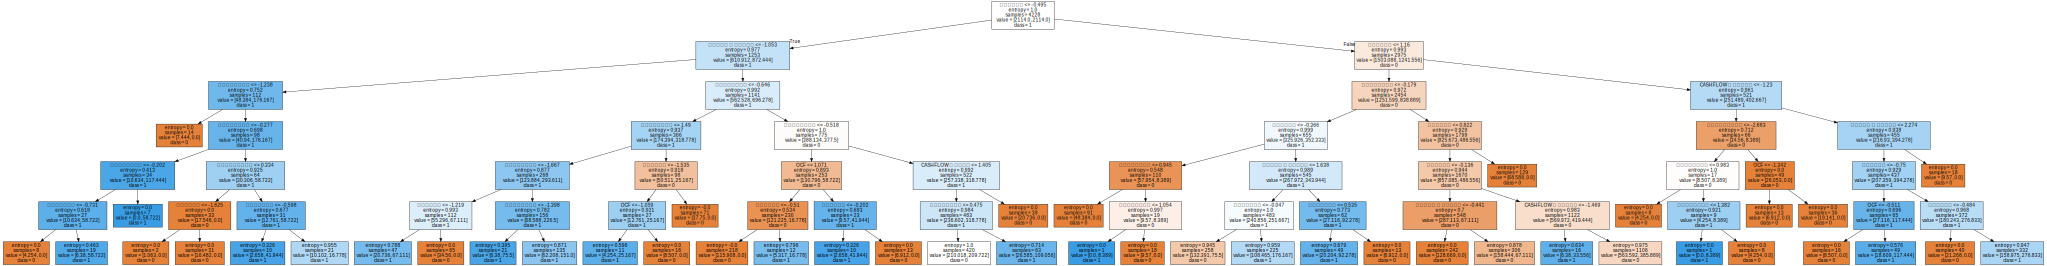

In [77]:
DT_vis(kosdaq_all, d_all)

SVM

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.13356787258620836

예측 데이터 정확도
accuracy score : 0.609
precision score : 0.124
recall score : 0.423
f1 score : 0.192
roc score : 0.527


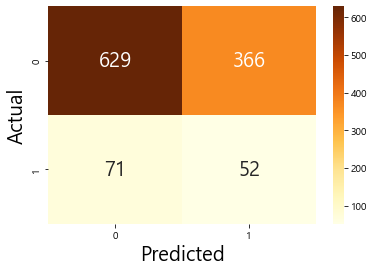

In [78]:
SVM(kosdaq_all, 'rbf')

In [79]:
# SVM(kosdaq_all, 'linear')

XGB

[21:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'gamma': 10.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.056726094003242, 'silent': 1}
학습 데이터 정확도 :  0.11097208306535422

예측 데이터 정확도
accuracy score : 0.875
precision score : 0.053
recall score : 0.008
f1 score : 0.014
roc score : 0.495
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.73703    0.14523 0.28455   0.19231    0.53876
0.30000   0.81664    0.12037 0.10569

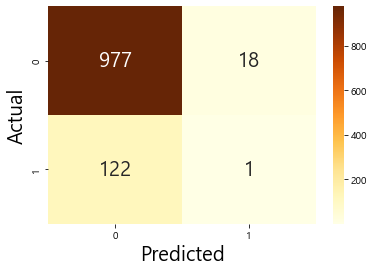

In [80]:
XGB(kosdaq_all)

##### 부정

Logistic Regression

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.11642183036763716

예측 데이터 정확도
accuracy score : 0.573
precision score : 0.103
recall score : 0.455
f1 score : 0.168
roc score : 0.520
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.09492    0.09492 1.00000   0.17338    0.50000
0.30000   0.09779    0.09519 1.00000   0.17384    0.50159
0.40000   0.17641    0.09402 0.88889   0.17005    0.49529
0.50000   0.57335    0.10321 0.45455   0.16822    0.52018
0.60000   0.81879    0.09821 0.11111   0.10427    0.50206
0.70000   0.89262    0.06667 0.01010   0.01754    0.49764
0.80000   0.90508    0.00000 0.00000   0.00000    0.50000
0.90000   0.90508    0.00000 0.00000   0.00000    0.50000
None


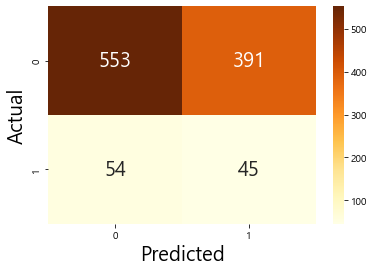

In [81]:
LG(kosdaq_bad)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.09763730391603063

예측 데이터 정확도
accuracy score : 0.321
precision score : 0.085
recall score : 0.626
f1 score : 0.149
roc score : 0.458
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.19367    0.08594 0.77778   0.15477    0.45510
0.30000   0.24161    0.08413 0.70707   0.15038    0.44993
0.40000   0.29338    0.08355 0.64646   0.14798    0.45141
0.50000   0.32119    0.08458 0.62626   0.14904    0.45773
0.60000   0.82550    0.05376 0.05051   0.05208    0.47864
0.70000   0.82550    0.05376 0.05051   0.05208    0.47864
0.80000   0.89070    0.00000 0.00000   0.00000    0.49206
0.90000   0.89262    0.00000 0.00000   0.00000    0.49311
None


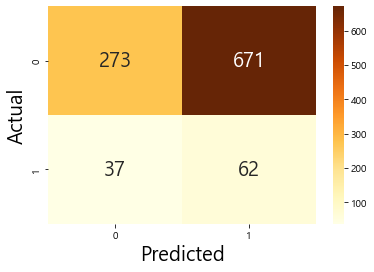

In [82]:
d_bad = DT(kosdaq_bad)

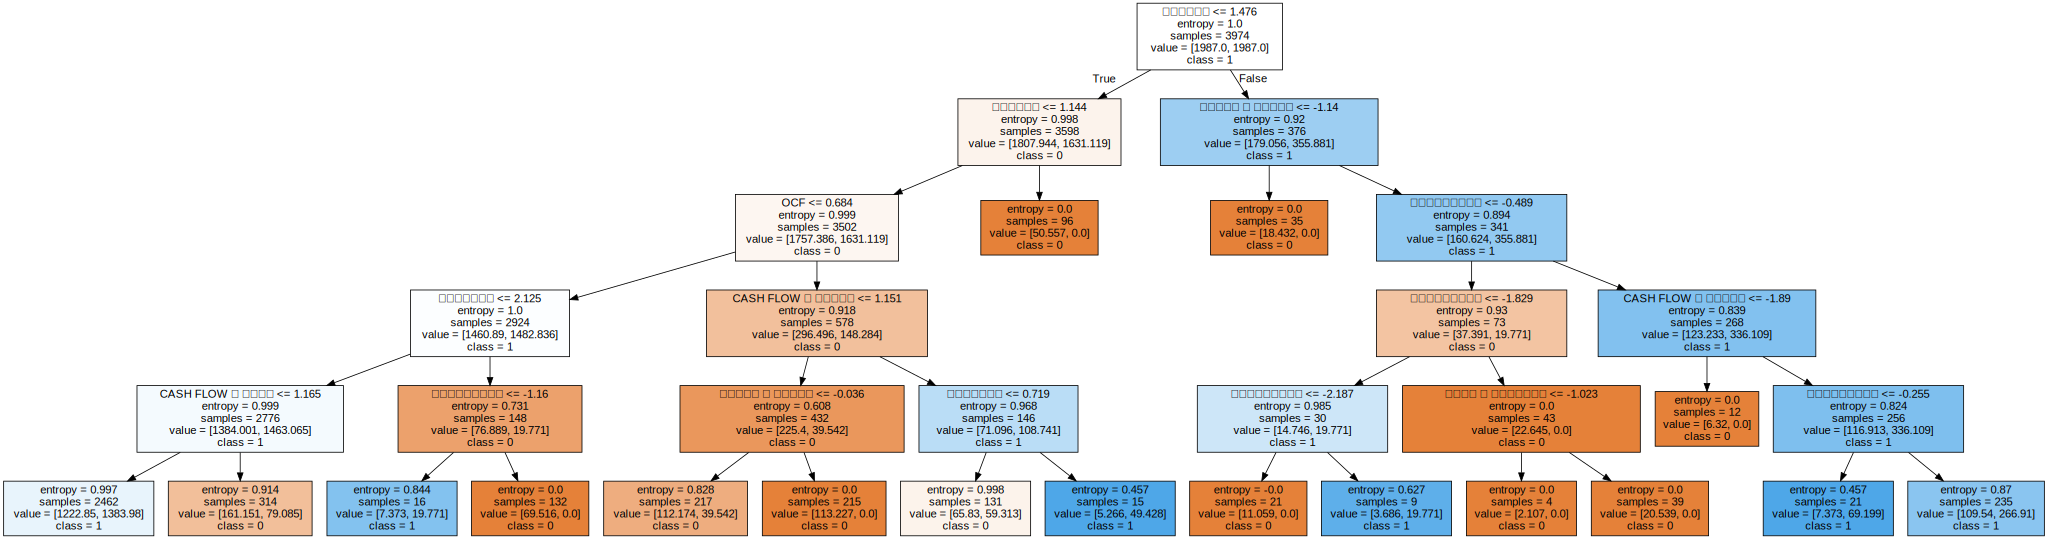

In [83]:
DT_vis(kosdaq_bad, d_bad)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.11762912534153336

예측 데이터 정확도
accuracy score : 0.634
precision score : 0.108
recall score : 0.394
f1 score : 0.170
roc score : 0.526


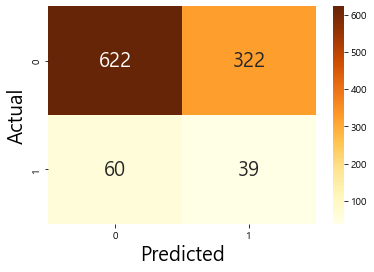

In [84]:
SVM(kosdaq_bad, 'rbf')

In [85]:
# SVM(kosdaq_bad, 'linear')

XGBoost

[21:40:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'gamma': 10.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 9.51008064516129, 'silent': 1}
학습 데이터 정확도 :  0.06601889338731444

예측 데이터 정확도
accuracy score : 0.885
precision score : 0.043
recall score : 0.010
f1 score : 0.016
roc score : 0.493
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.72100    0.11290 0.28283   0.16138    0.52489
0.30000   0.81016    0.11628 0.15152 

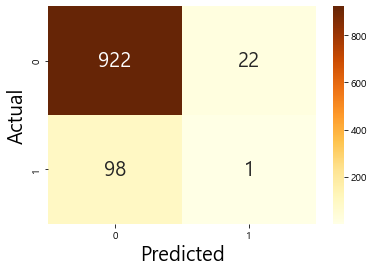

In [86]:
XGB(kosdaq_bad)

##### 건전

Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.3831002331002331

예측 데이터 정확도
accuracy score : 0.547
precision score : 0.375
recall score : 0.625
f1 score : 0.469
roc score : 0.567
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.32000    0.32000 1.00000   0.48485    0.50000
0.30000   0.32000    0.32000 1.00000   0.48485    0.50000
0.40000   0.33333    0.32432 1.00000   0.48980    0.50980
0.50000   0.54667    0.37500 0.62500   0.46875    0.56740
0.60000   0.69333    0.60000 0.12500   0.20690    0.54289
0.70000   0.68000    0.00000 0.00000   0.00000    0.50000
0.80000   0.68000    0.00000 0.00000   0.00000    0.50000
0.90000   0.68000    0.00000 0.00000   0.00000    0.50000
None


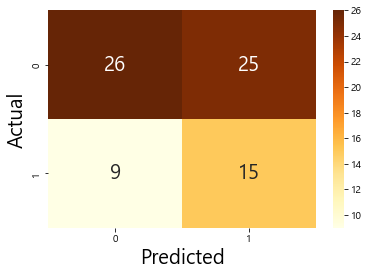

In [87]:
LG(kosdaq_good)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.386477873977874

예측 데이터 정확도
accuracy score : 0.547
precision score : 0.375
recall score : 0.625
f1 score : 0.469
roc score : 0.567
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.54667    0.37500 0.62500   0.46875    0.56740
0.30000   0.54667    0.37500 0.62500   0.46875    0.56740
0.40000   0.54667    0.37500 0.62500   0.46875    0.56740
0.50000   0.54667    0.37500 0.62500   0.46875    0.56740
0.60000   0.65333    0.41667 0.20833   0.27778    0.53554
0.70000   0.65333    0.41667 0.20833   0.27778    0.53554
0.80000   0.65333    0.41667 0.20833   0.27778    0.53554
0.90000   0.65333    0.41667 0.20833   0.27778    0.53554
None


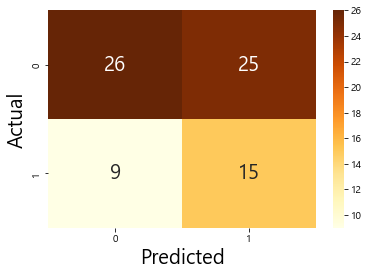

In [88]:
d_good = DT(kosdaq_good)

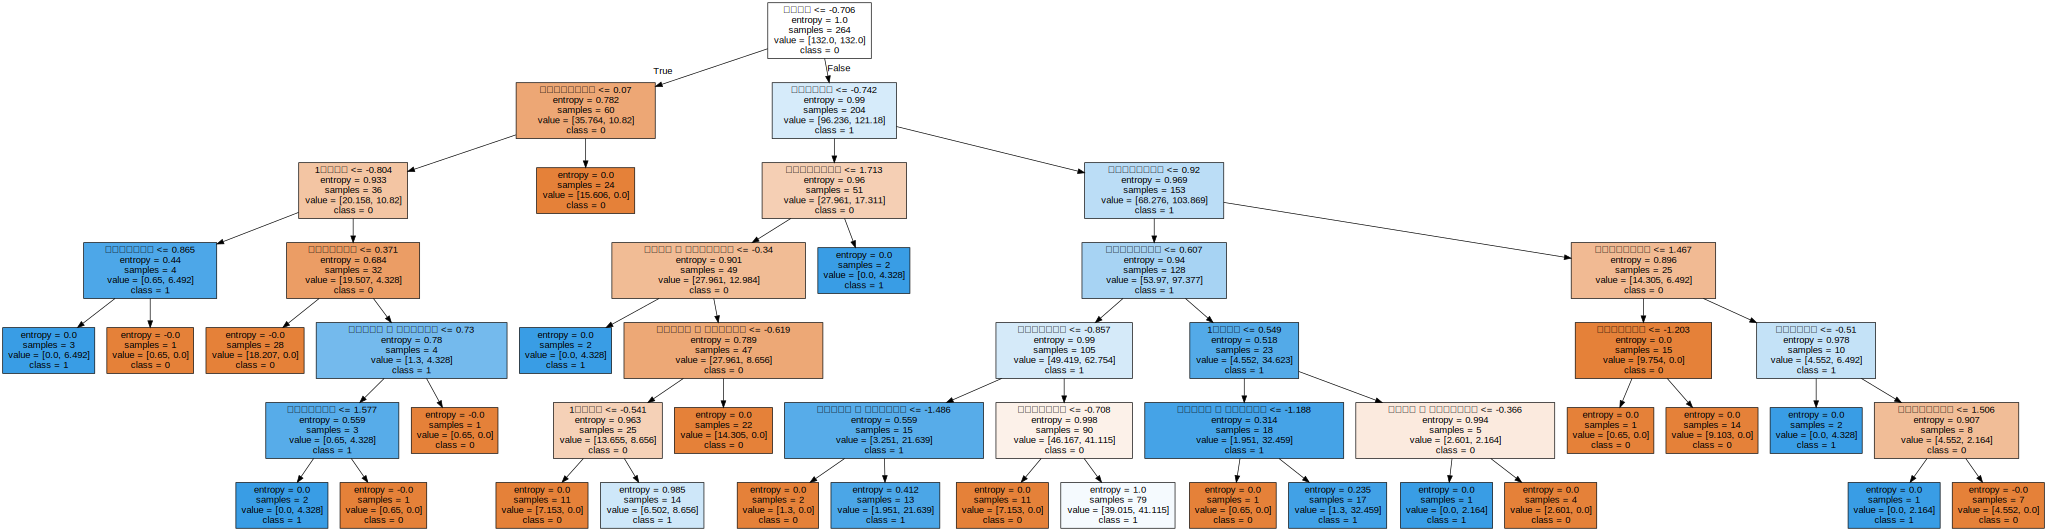

In [89]:
DT_vis(kosdaq_good, d_good)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.3715341091064375

예측 데이터 정확도
accuracy score : 0.533
precision score : 0.343
recall score : 0.500
f1 score : 0.407
roc score : 0.525


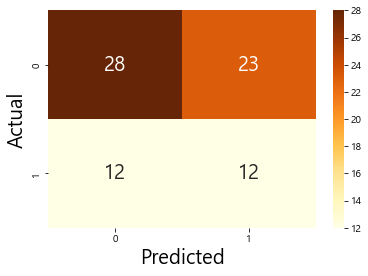

In [90]:
SVM(kosdaq_good, 'rbf')

In [91]:
# SVM(kosdaq_good, 'linear')

XGB

[21:40:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 2.0991735537190084, 'silent': 1}
학습 데이터 정확도 :  0.3035551163812033

예측 데이터 정확도
accuracy score : 0.707
precision score : 0.600
recall score : 0.250
f1 score : 0.353
roc score : 0.586
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.66667    0.48148 0.54167   0.50980    0.63358
0.30000   0.73333    0.61111 0.45833

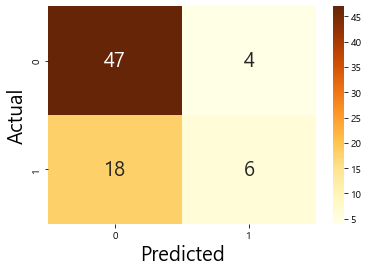

In [92]:
XGB(kosdaq_good)